In [1]:
import pandas as pd
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import datetime

In [2]:
import geopandas

In [3]:
with open('../data/signal_names.csv','r') as f:
    signal_list = [line.strip().split(',') for line in f.readlines()]
    

signals_df = pd.DataFrame([line[:2] + sorted(line[2:]) for line in signal_list[1:]], columns = signal_list[0])
signals_df['intersection'] = signals_df['cross_street_1'] + ' & ' + signals_df['cross_street_2']
signals_df = signals_df[signals_df['cross_street_1'] != 'no_int_found']
signals_df = signals_df[['intersection', 'lat', 'lon']].drop_duplicates('intersection').reset_index().drop('index',axis=1)
signals_df['lat'] = signals_df['lat'].astype(float)
signals_df['lon'] = signals_df['lon'].astype(float)
signals_df.head()

,intersection,lat,lon
0,Central Park W & W 106th St,40.798049,-73.960043
1,Manhattan Ave & W 106th St,40.798645,-73.961474
2,Columbus Ave & W 106th St,40.799255,-73.962886
3,Amsterdam Ave & W 106th St,40.800431,-73.965705
4,Broadway & W 106th St,40.801401,-73.967994


In [4]:
traffic_df = pd.read_csv('../data/Traffic_Volume_Counts__2014-2018_.csv')
traffic_df.head()

,ID,Segment ID,Roadway Name,From,To,Direction,Date,12:00-1:00 AM,1:00-2:00AM,2:00-3:00AM,...,2:00-3:00PM,3:00-4:00PM,4:00-5:00PM,5:00-6:00PM,6:00-7:00PM,7:00-8:00PM,8:00-9:00PM,9:00-10:00PM,10:00-11:00PM,11:00-12:00AM
0,2,70376,3 Avenue,East 154 Street,East 155 Street,NB,09/13/2014,204.0,177.0,133.0,...,520,611,573,546,582,528,432,328,282,240
1,2,70376,3 Avenue,East 155 Street,East 154 Street,SB,09/13/2014,140.0,51.0,128.0,...,379,376,329,362,418,335,282,247,237,191
2,56,176365,Bedford Park Boulevard,Grand Concourse,Valentine Avenue,EB,09/13/2014,94.0,73.0,65.0,...,280,272,264,236,213,190,199,183,147,103
3,56,176365,Bedford Park Boulevard,Grand Concourse,Valentine Avenue,WB,09/13/2014,88.0,82.0,75.0,...,237,276,223,240,217,198,186,162,157,103
4,62,147673,Broadway,West 242 Street,240 Street,SB,09/13/2014,255.0,209.0,149.0,...,732,809,707,675,641,556,546,465,425,324


In [5]:
#dates = pd.to_datetime(traffic_df['Date'], format='%m/%d/%Y')
#dates_2018 = dates>datetime.datetime(2017,12,31)
traffic_2018_df = traffic_df#[dates_2018]
traffic_2018_df.head()

,ID,Segment ID,Roadway Name,From,To,Direction,Date,12:00-1:00 AM,1:00-2:00AM,2:00-3:00AM,...,2:00-3:00PM,3:00-4:00PM,4:00-5:00PM,5:00-6:00PM,6:00-7:00PM,7:00-8:00PM,8:00-9:00PM,9:00-10:00PM,10:00-11:00PM,11:00-12:00AM
0,2,70376,3 Avenue,East 154 Street,East 155 Street,NB,09/13/2014,204.0,177.0,133.0,...,520,611,573,546,582,528,432,328,282,240
1,2,70376,3 Avenue,East 155 Street,East 154 Street,SB,09/13/2014,140.0,51.0,128.0,...,379,376,329,362,418,335,282,247,237,191
2,56,176365,Bedford Park Boulevard,Grand Concourse,Valentine Avenue,EB,09/13/2014,94.0,73.0,65.0,...,280,272,264,236,213,190,199,183,147,103
3,56,176365,Bedford Park Boulevard,Grand Concourse,Valentine Avenue,WB,09/13/2014,88.0,82.0,75.0,...,237,276,223,240,217,198,186,162,157,103
4,62,147673,Broadway,West 242 Street,240 Street,SB,09/13/2014,255.0,209.0,149.0,...,732,809,707,675,641,556,546,465,425,324


In [6]:
traffic_2018_df.groupby(['Segment ID','Roadway Name','From','To']).mean()

,,,,ID,12:00-1:00 AM,1:00-2:00AM,2:00-3:00AM,3:00-4:00AM,4:00-5:00AM,5:00-6:00AM,6:00-7:00AM,7:00-8:00AM,8:00-9:00AM,...,2:00-3:00PM,3:00-4:00PM,4:00-5:00PM,5:00-6:00PM,6:00-7:00PM,7:00-8:00PM,8:00-9:00PM,9:00-10:00PM,10:00-11:00PM,11:00-12:00AM
Segment ID,Roadway Name,From,To,,,,,,,,,,,,,,,,,,,,,
202,Main Street,Hoover Avenue,82 Drive,200.000000,305.000000,222.000000,137.000000,138.000000,114.000000,155.000000,283.000000,355.000000,485.000000,...,665.000000,649.000000,671.000000,700.000000,658.000000,646.000000,707.000000,620.000000,540.000000,504.000000
1416,BLOOMINGDALE ROAD,RAMONA AVENUE,HARGOLD AVENUE,290.000000,61.722222,35.833333,19.388889,17.388889,26.388889,54.000000,118.000000,217.277778,246.222222,...,352.833333,348.888889,346.888889,353.166667,319.611111,261.777778,210.333333,156.055556,113.666667,81.166667
1883,FOSTER ROAD,RATHBUN AVENUE,RAMONA AVENUE,296.000000,61.388889,39.277778,20.555556,13.444444,20.611111,47.944444,119.000000,255.333333,241.666667,...,351.166667,348.055556,351.111111,340.333333,337.388889,274.888889,211.611111,160.277778,112.055556,88.944444
2147,HUGUENOT AVENUE,RAMONA AVENUE,RATHBUN AVENUE,371.000000,57.111111,37.666667,21.722222,17.722222,26.666667,60.555556,148.722222,291.944444,262.611111,...,393.777778,401.388889,370.611111,389.166667,363.388889,305.500000,245.277778,178.888889,125.277778,85.722222
2367,ARTHUR KILL ROAD,MAZZA COURT,KRISSA COURT,297.000000,84.833333,52.500000,36.500000,33.333333,64.666667,152.722222,236.777778,319.944444,384.166667,...,446.444444,444.000000,446.666667,453.277778,415.277778,344.500000,268.388889,198.222222,144.833333,106.555556
2369,ARTHUR KILL ROAD,CARLYLE GREEN,KRISSA COURT,321.000000,84.666667,53.722222,35.777778,33.777778,64.888889,158.944444,242.888889,329.666667,394.277778,...,456.333333,453.500000,452.555556,456.888889,412.166667,345.666667,268.166667,200.111111,144.111111,106.444444
2760,WOODROW ROAD,DELMAR AVENUE,EVERTON AVENUE,293.000000,27.388889,15.055556,10.111111,9.000000,14.055556,35.500000,63.888889,151.777778,133.000000,...,191.944444,169.611111,166.500000,160.611111,170.444444,134.166667,103.722222,74.000000,51.222222,39.111111
2933,AMBOY ROAD,ROSE LANE,ARBUTUS AVENUE,318.000000,65.000000,38.555556,22.555556,13.166667,12.444444,27.333333,81.222222,349.222222,308.888889,...,443.055556,384.277778,346.722222,353.555556,324.777778,283.055556,219.500000,164.888889,111.944444,82.611111
2984,KOREAN WAR VETS PARKWAY SR,HEENAN AVENUE,ALBEE AVENUE,277.000000,22.666667,13.333333,9.000000,6.111111,8.111111,13.444444,35.000000,96.888889,126.222222,...,171.888889,169.000000,150.666667,147.222222,133.888889,101.555556,80.444444,58.888889,42.333333,29.444444


In [7]:
with open('../data/NYC_LION_lines-geojson.json','r') as f:
    LION_lines_json = json.load(f)

In [8]:
from shapely.geometry import MultiLineString
LION_dict = {int(feature['properties']['segmentid']): MultiLineString(feature['geometry']['coordinates'])  for feature in LION_lines_json['features']}


In [21]:
[feature['properties']['street'] for feature in LION_lines_json['features'] if int(feature['properties']['segmentid']) == 18060]

[]

In [9]:
traffic_2018_df['lines'] = traffic_2018_df['Segment ID'].map(LION_dict)

In [10]:
avg_traffic_2018 = traffic_2018_df.groupby(['Segment ID']).mean().loc[:,'12:00-1:00 AM':].sum(axis=1)

In [18]:
avg_traf = avg_traffic_2018.sort_index()
avg_traf.head(2)

Segment ID
202     11459.000000
1416     4752.388889
dtype: float64

In [13]:
len(traffic_2018_df['Segment ID'])

21448

In [19]:
lines = traffic_2018_df.drop_duplicates(subset='Segment ID').set_index('Segment ID').sort_index()

In [20]:
traffic_avg_df = pd.concat([avg_traf,lines],axis=1).rename(columns={0: 'avg_traffic'}).dropna()
traffic_avg_df.to_pickle('../data/2014-2018_traffic_avgs.pkl')

In [21]:
import geopandas
from geopandas import GeoDataFrame

In [22]:
from shapely.geometry import Point
from shapely.geometry import MultiLineString
from shapely.wkt import loads


signals_df['coord'] = list(zip(*(signals_df['lat'],signals_df['lon'])))
signals_df['pt'] = signals_df['coord'].map(lambda x: Point(x[::-1]))

In [23]:
geo_signals = GeoDataFrame(signals_df['pt'], geometry='pt',crs="+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
geo_signals = geo_signals.to_crs("+init=epsg:32618")

In [24]:
geo_traffic = GeoDataFrame(traffic_avg_df, geometry='lines',crs="+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
geo_traffic = geo_traffic.to_crs("+init=epsg:32618")

In [25]:
pt = geo_signals.loc[0,'pt']
geo_traffic['lines'].distance(pt).min()

483.2047099493374

In [ ]:
geo_signals['veh_traffic'] = np.zeros(geo_signals['pt'].shape)

for ix in signals_df.index:
    point = geo_signals.loc[ix,'pt']
    geo_signals
    locs = geo_humps_df[geo_humps_df['lines'].distance(point) < 10].index
    if len(locs) != 0:
        geo_signals_df.loc[ix,'num_bumps'] = geo_humps_df.loc[locs,'new_humps'].sum()
        geo_signals_df.loc[ix,'len_bumps'] = geo_humps_df.loc[locs,'length'].sum()
    if ix in range(1000,10000,1000):
        print(ix)

In [26]:
geo_signals[signals_df['lat']==signals_df['lat'].min()],geo_signals[signals_df['lat']==signals_df['lat'].max()]

(                                              pt
 8732  POINT (564254.538720209 4484067.286165216),
                                                pt
 6434  POINT (592297.3001831237 4528995.994054401))

In [27]:
geo_signals[signals_df['lon']==signals_df['lon'].min()],geo_signals[signals_df['lon']==signals_df['lon'].max()]

(                                               pt
 8752  POINT (563804.5327357554 4484531.114211939),
                                                pt
 7557  POINT (609723.5389228354 4510602.442769557))

In [28]:
bb = [[4480000, 4530000],[560000, 610000]]
bb

[[4480000, 4530000], [560000, 610000]]

In [29]:
geo_traffic.head()

,avg_traffic,ID,Roadway Name,From,To,Direction,Date,12:00-1:00 AM,1:00-2:00AM,2:00-3:00AM,...,3:00-4:00PM,4:00-5:00PM,5:00-6:00PM,6:00-7:00PM,7:00-8:00PM,8:00-9:00PM,9:00-10:00PM,10:00-11:00PM,11:00-12:00AM,lines
Segment ID,,,,,,,,,,,,,,,,,,,,,
202,11459.000000,200,Main Street,Hoover Avenue,82 Drive,SB,10/11/2014,305.0,222.0,137.0,...,649,671,700,658,646,707,620,540,504,(LINESTRING (563673.9744119872 4485132.6325586...
1416,4752.388889,290,BLOOMINGDALE ROAD,RAMONA AVENUE,HARGOLD AVENUE,NB,10/24/2015,76.0,47.0,28.0,...,385,370,315,339,250,218,233,174,116,(LINESTRING (566229.2940085845 4487126.7844499...
1883,4756.500000,296,FOSTER ROAD,RATHBUN AVENUE,RAMONA AVENUE,NB,10/24/2015,104.0,65.0,44.0,...,351,341,348,398,289,286,228,169,151,(LINESTRING (567327.6999981041 4487609.5130578...
2147,5313.833333,371,HUGUENOT AVENUE,RAMONA AVENUE,RATHBUN AVENUE,NB,03/05/2016,0.0,0.0,0.0,...,412,347,368,287,297,251,204,156,122,(LINESTRING (568106.0348023821 4487987.4616463...
2367,6676.055556,297,ARTHUR KILL ROAD,MAZZA COURT,KRISSA COURT,EB,10/24/2015,107.0,68.0,40.0,...,336,393,347,314,256,162,175,115,107,(LINESTRING (567725.4075254835 4489842.3148838...


In [44]:
def car_traffic_test(df, arr1, arr2):
    z = np.zeros(shape=(arr1.size,arr2.size))
    for iy, y in enumerate(arr1):
        for ix, x in enumerate(arr2):
            pt = Point((x,y))
            z[iy,ix] = (df['avg_traffic']*np.exp(-df['lines'].distance(pt)**2/10**4)).sum()
    return z

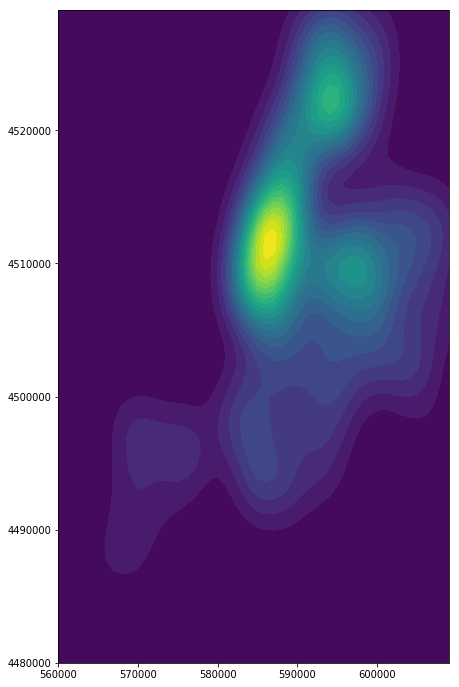

In [45]:
fig = plt.figure(figsize = (12,12))
ax = plt.gca()
ax.set_aspect(1.67)
y = np.arange(bb[0][0],bb[0][1],1000)
x = np.arange(bb[1][0],bb[1][1],1000)
xx, yy = np.meshgrid(y, x, sparse=True)
z = bike_traffic_test(geo_traffic,y,x)
h = plt.contourf(x,y,z,levels = 20)
plt.show()

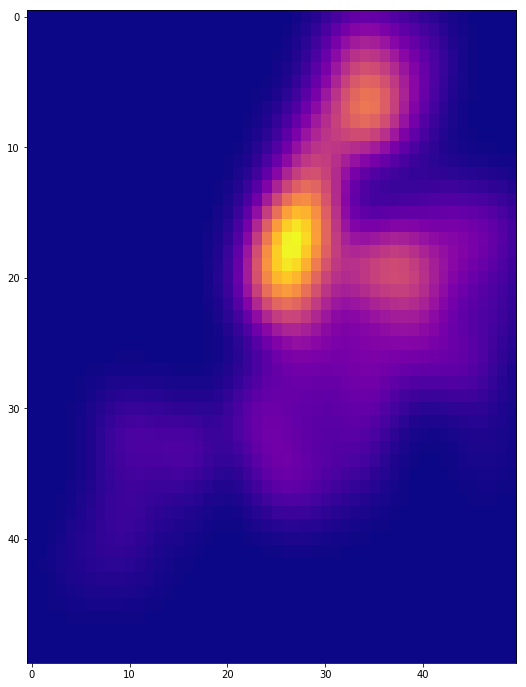

In [46]:
fig = plt.figure(figsize = (12,12))
ax = fig.gca()
ax.set_aspect(0.1)
plt.imshow(np.flip(z,axis=0), cmap='plasma',interpolation='nearest', aspect = 4/3)
#plt.savefig('../Images/MC_bike_traffic_2018_est.png')
plt.show()

In [ ]:
(df['avg_traffic']*np.exp(-df['lines'].distance(pt)**2/10**6)).sum()

In [39]:
def car_traffic(df, pt, sigma):
    return (df['avg_traffic']*np.exp(-df['lines'].distance(pt)**2/sigma)).sum()

In [38]:
def pkl_bike_traffic(signals_df, bike_traffic_stations_df, sigma_power):
    df= signals_df.copy()
    df['car_traffic'] = df['pt'].map(lambda x: car_traffic(geo_traffic, x, 10**sigma_power))
    df['car_traffic'].to_pickle('../data/pickles/2018/signals_car_traffic_2018_sigma_{}.pkl'.format(sigma_power))
    return

In [49]:
[pkl_bike_traffic(geo_signals,geo_traffic,sigma_power) for sigma_power in range(7,10)]

[None, None, None]